In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from PIL import Image
from glob import glob

np.random.seed(42)
from sklearn.metrics import confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
skin_df = pd.read_csv('./dataset/HAM10000_metadata.csv')

#### Load images size

In [3]:
SIZE=32 # 32/64

#### Label encoding to numeric values from text

In [4]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()

LabelEncoder()

In [5]:
list(le.classes_)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [6]:
skin_df['label'] = le.transform(skin_df['dx'])
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,4
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,5
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,4
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,2
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,5
8071,HAM_0006333,ISIC_0024424,nv,histo,35.0,male,trunk,5
7423,HAM_0004548,ISIC_0032832,nv,histo,45.0,female,upper extremity,5
8984,HAM_0006526,ISIC_0026671,nv,histo,55.0,male,lower extremity,5
2310,HAM_0003102,ISIC_0032389,mel,histo,65.0,male,face,4
7256,HAM_0004260,ISIC_0025525,nv,histo,65.0,male,back,5


#### Visualize the data distribution

C:\Users\User\AppData\Local\Temp\ipykernel_9960\2117755175.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red')


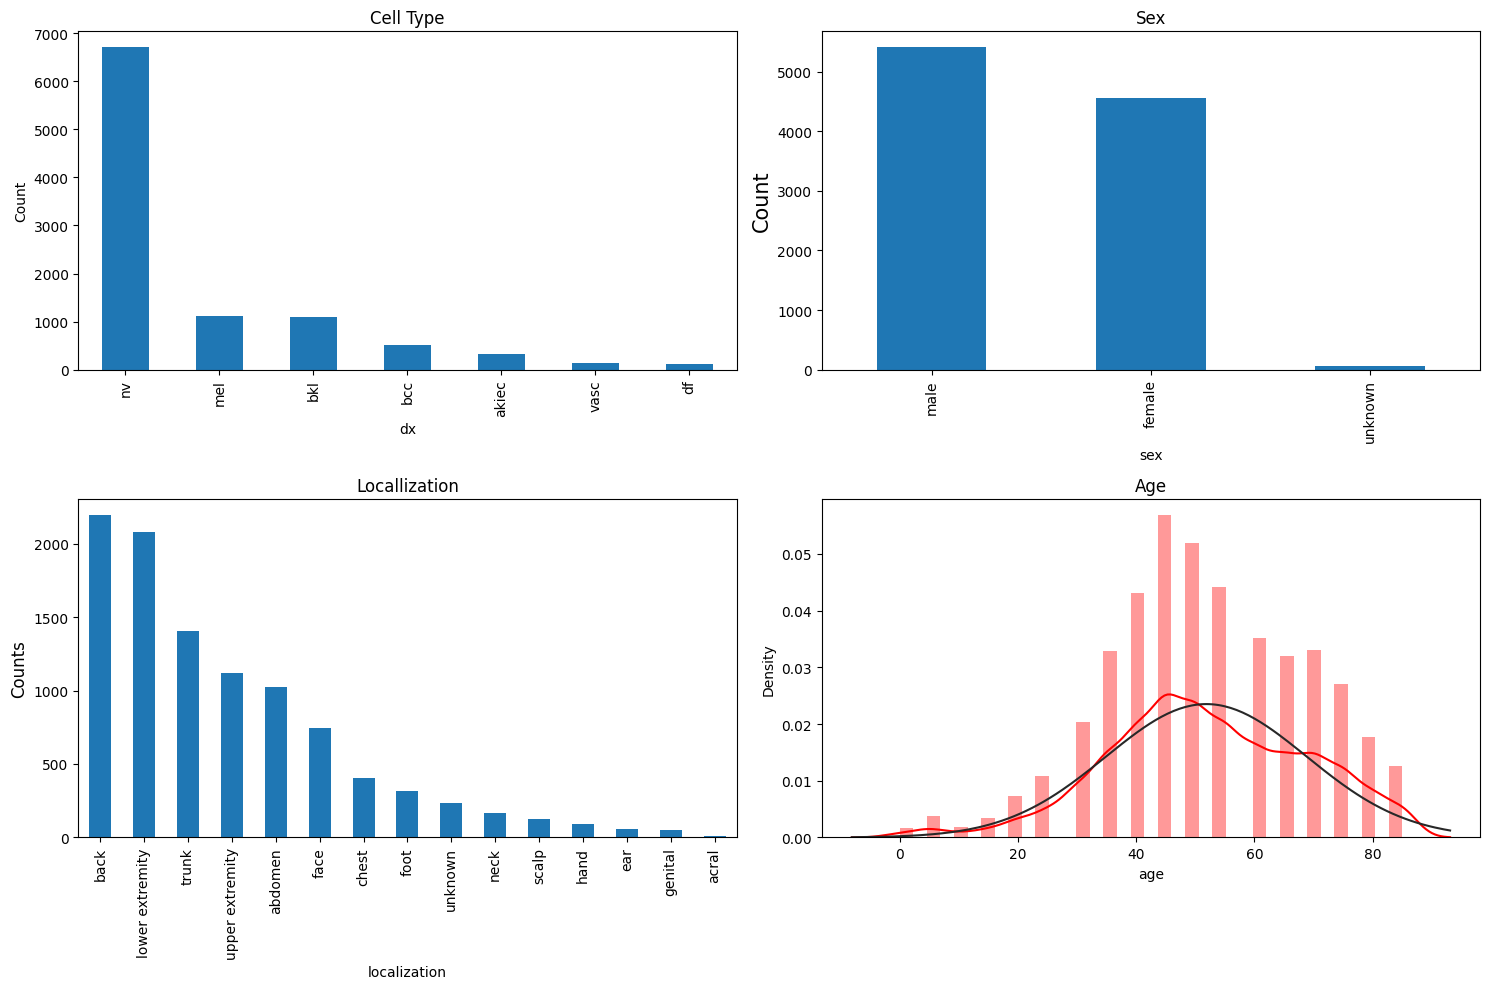

In [7]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel("Count")
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel("Count", size=15)
ax2.set_title('Sex')

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Counts', size=12)
ax3.set_title('Locallization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red')
ax4.set_title("Age")

plt.tight_layout()
plt.show()

#### Check distribution of various classes

In [8]:
skin_df['label'].value_counts()

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64

#### Balance Data  

###### Need to change this part

In [9]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=1000

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#### Combine back to a single dataframe

In [10]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced,
                              df_6_balanced])

In [11]:
skin_df_balanced['label'].value_counts()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: count, dtype: int64

#### Read images based on image ID from the CSV file

In [12]:
image_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('dataset/', '*', '*.jpg'))}

In [13]:
image_path

{'ISIC_0024306': 'dataset\\HAM10000_new_folder\\ISIC_0024306.jpg',
 'ISIC_0024307': 'dataset\\HAM10000_new_folder\\ISIC_0024307.jpg',
 'ISIC_0024308': 'dataset\\HAM10000_new_folder\\ISIC_0024308.jpg',
 'ISIC_0024309': 'dataset\\HAM10000_new_folder\\ISIC_0024309.jpg',
 'ISIC_0024310': 'dataset\\HAM10000_new_folder\\ISIC_0024310.jpg',
 'ISIC_0024311': 'dataset\\HAM10000_new_folder\\ISIC_0024311.jpg',
 'ISIC_0024312': 'dataset\\HAM10000_new_folder\\ISIC_0024312.jpg',
 'ISIC_0024313': 'dataset\\HAM10000_new_folder\\ISIC_0024313.jpg',
 'ISIC_0024314': 'dataset\\HAM10000_new_folder\\ISIC_0024314.jpg',
 'ISIC_0024315': 'dataset\\HAM10000_new_folder\\ISIC_0024315.jpg',
 'ISIC_0024316': 'dataset\\HAM10000_new_folder\\ISIC_0024316.jpg',
 'ISIC_0024317': 'dataset\\HAM10000_new_folder\\ISIC_0024317.jpg',
 'ISIC_0024318': 'dataset\\HAM10000_new_folder\\ISIC_0024318.jpg',
 'ISIC_0024319': 'dataset\\HAM10000_new_folder\\ISIC_0024319.jpg',
 'ISIC_0024320': 'dataset\\HAM10000_new_folder\\ISIC_0024320.j

In [14]:
# Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [15]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,dataset\HAM10000_new_folder\ISIC_0026645.jpg
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,dataset\HAM10000_new_folder\ISIC_0025780.jpg
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,dataset\HAM10000_new_folder\ISIC_0024450.jpg
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,dataset\HAM10000_new_folder\ISIC_0027896.jpg
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,dataset\HAM10000_new_folder\ISIC_0029268.jpg


In [16]:
# Use the path to read image
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

#### Plot the images again

In [17]:
# need to learn
n_samples = 5

# fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
# for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(by=['dx']).groupby('dx')):
#     n_axs[0].set_title(type_name)
    # for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
    #     c_ax.imshow(c_row['image'])
    #     c_ax.axis('off')

In [18]:
# Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. 
Y = skin_df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#### Define model

In [19]:
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 batch_normalization (Batch  (None, 30, 30, 256)       1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 128)       5

#### Train

In [20]:
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
329/329 - 45s - loss: 1.8824 - acc: 0.3834 - val_loss: 2.2155 - val_acc: 0.1349 - 45s/epoch - 137ms/step
Epoch 2/50
329/329 - 46s - loss: 1.3777 - acc: 0.4827 - val_loss: 1.3671 - val_acc: 0.4309 - 46s/epoch - 140ms/step
Epoch 3/50
329/329 - 55s - loss: 1.2285 - acc: 0.5478 - val_loss: 1.3780 - val_acc: 0.4663 - 55s/epoch - 166ms/step
Epoch 4/50


KeyboardInterrupt: 

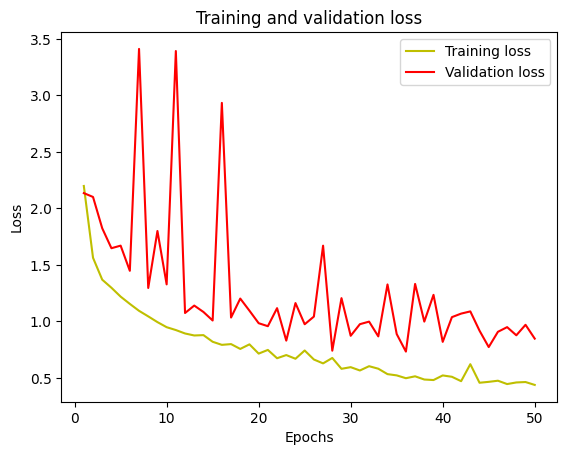

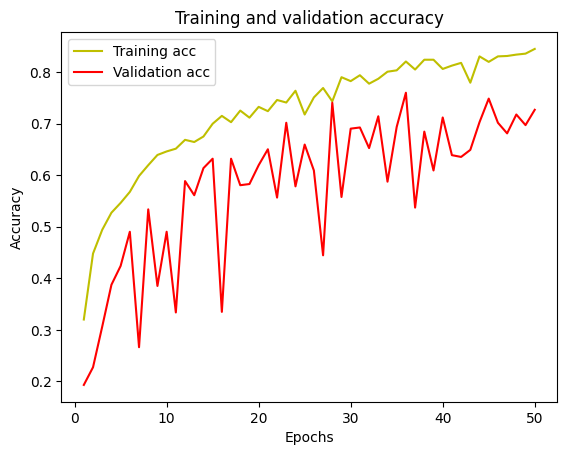

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 [==============================] - 2s 48ms/step


Text(45.722222222222214, 0.5, 'Fraction of incorrect predictions')

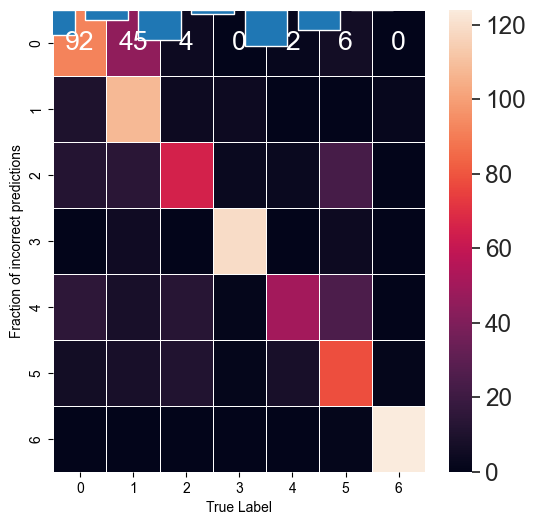

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')